In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('Sarcasm_Headlines_Dataset.json'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
import gensim.models
import fasttext
from keras.utils.vis_utils import plot_model
from gensim.models import KeyedVectors
import shutil


ModuleNotFoundError: No module named 'fasttext'

In [15]:
!pip install wordcloud

In [4]:
df = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
df.head()
df2 = df.copy()

In [5]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [6]:

Newspaper = []
for row in df['article_link']:
    if 'theonion.com' in row : Newspaper.append('The Onion')
    elif 'huffingtonpost.com' in row : Newspaper.append('Huffington Post')
    else: Newspaper.append('Something else')
# Create set to check the unique values of 'Newspaper'
set_Newspaper = set(Newspaper) 
print(set_Newspaper)
df['Web-site'] = Newspaper


{'The Onion', 'Huffington Post'}


In [7]:
df.drop('article_link', axis = 1, inplace = True)

In [8]:
df.head()

,headline,is_sarcastic,Web-site
0,former versace store clerk sues over secret 'b...,0,Huffington Post
1,the 'roseanne' revival catches up to our thorn...,0,Huffington Post
2,mom starting to fear son's web series closest ...,1,The Onion
3,"boehner just wants wife to listen, not come up...",1,The Onion
4,j.k. rowling wishes snape happy birthday in th...,0,Huffington Post


**Sarcastic and Non-sarcastic news headlines counts according to website:**

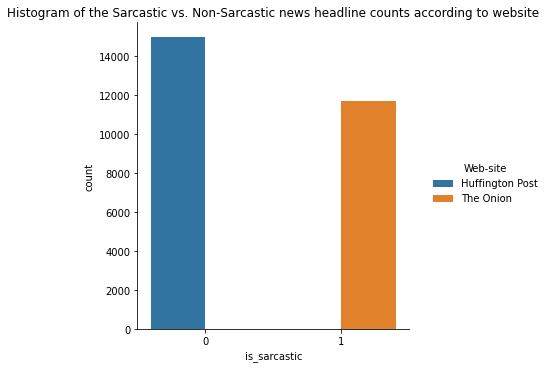

In [9]:
sns.catplot(data=df, x="is_sarcastic", hue="Web-site", kind="count").set(title='Histogram of the Sarcastic vs. Non-Sarcastic news headline counts according to website') 


In [10]:
sarcastic_word_count=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
non_sarcastic_word_count=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))


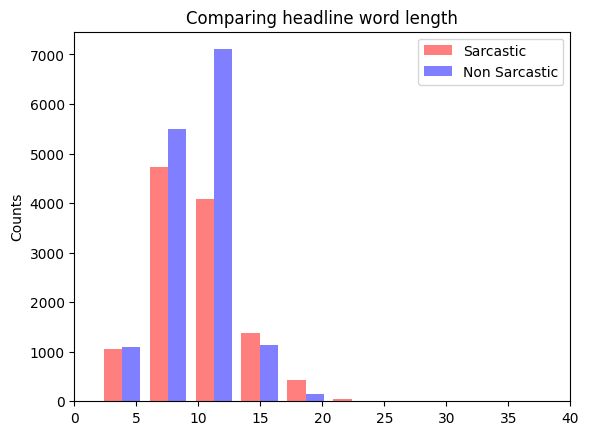

In [11]:
plt.hist([sarcastic_word_count, non_sarcastic_word_count], color=['r','b'], alpha=0.5)
plt.title('Comparing headline word length')
plt.legend(['Sarcastic','Non Sarcastic'])
plt.xlim(0,40)
plt.ylabel('Counts')
plt.show()


In [12]:
sarcastic_headline_char_count=df[df['is_sarcastic']==1]['headline'].str.len()
non_sarcastic_headline_char_count=df[df['is_sarcastic']==0]['headline'].str.len()


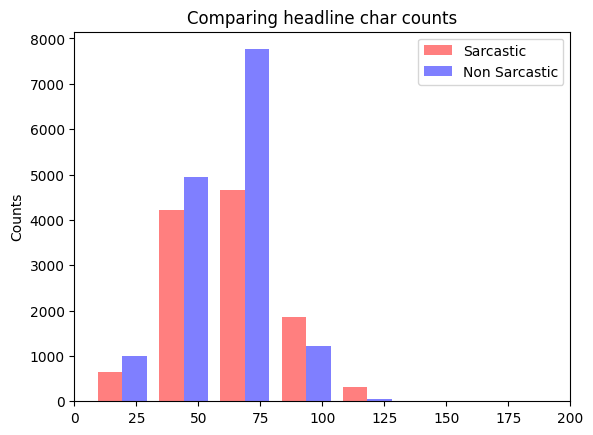

In [13]:
plt.hist([sarcastic_headline_char_count, non_sarcastic_headline_char_count], color=['r','b'], alpha=0.5)
plt.title('Comparing headline char counts')
plt.legend(['Sarcastic','Non Sarcastic'])
plt.xlim(0,200)
plt.ylabel('Counts')
plt.show()


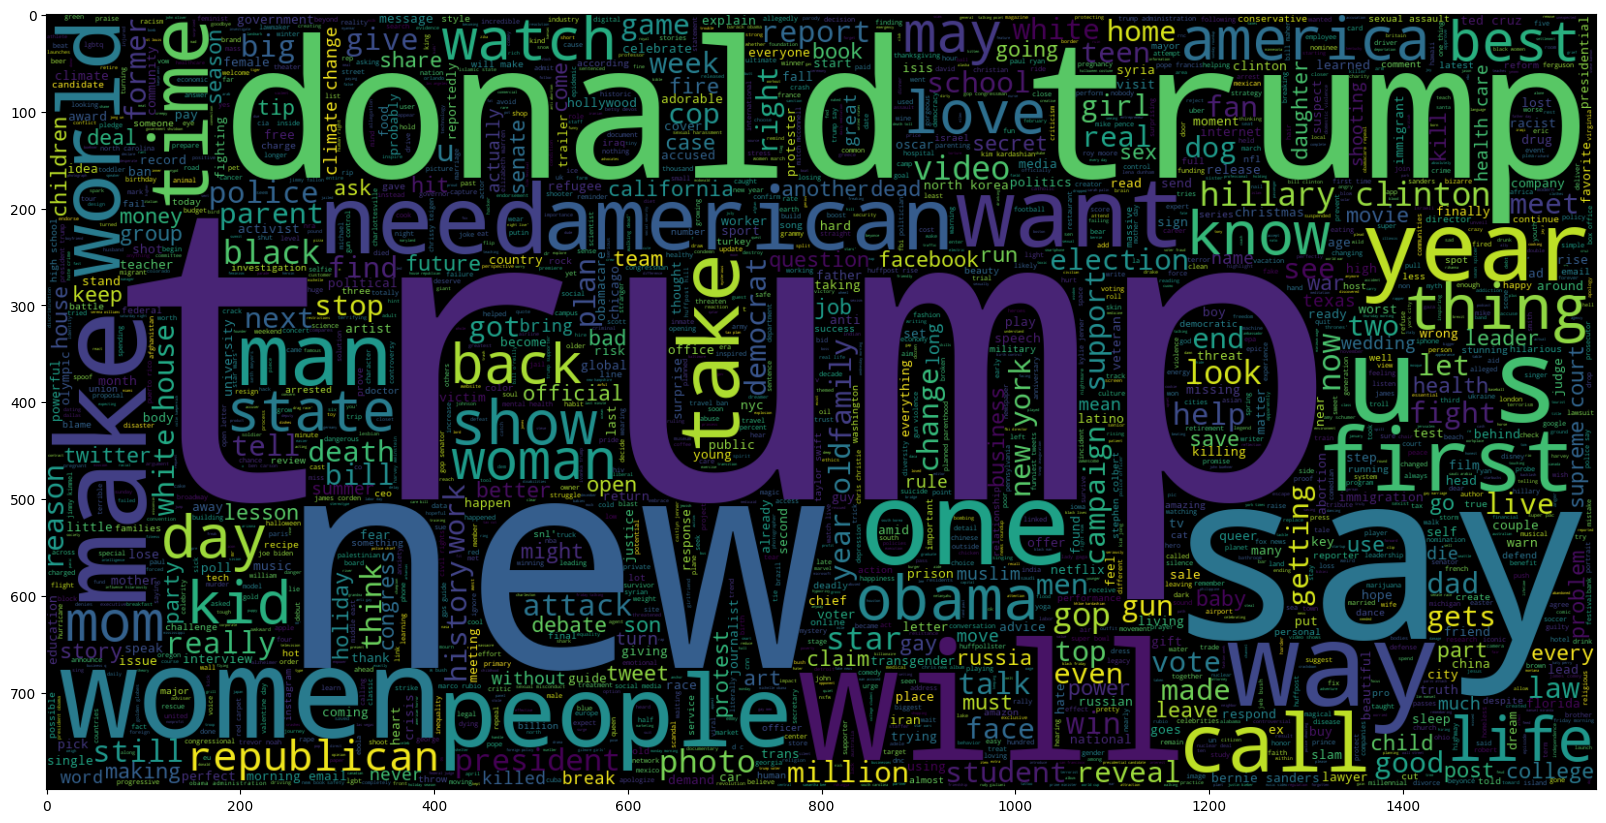

In [19]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')


In [20]:
non_sarcastic_frequent_words_list = list(wc.words_.keys())[:20]
print(non_sarcastic_frequent_words_list[:10])

['trump', 'new', 'say', 'donald trump', 'will', 'women', 'make', 'u s', 'way', 'one']


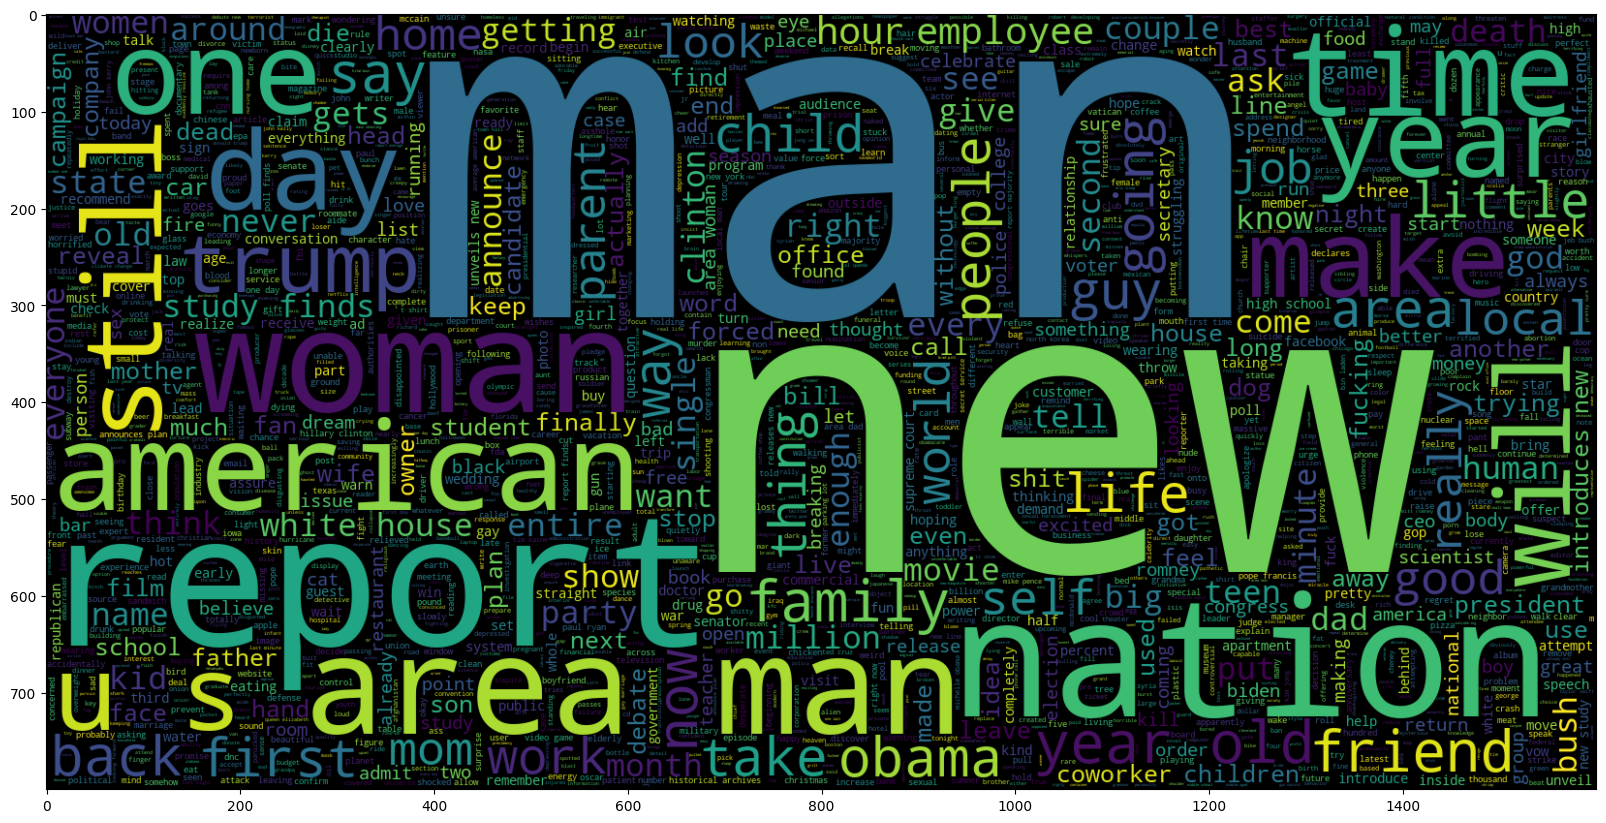

In [21]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')


In [22]:
sarcastic_frequent_words_list = list(wc.words_.keys())[:20]
print(sarcastic_frequent_words_list[:10])

['man', 'new', 'report', 'nation', 'woman', 'area man', 'american', 'time', 'one', 'year']


In [23]:

s = set(sarcastic_frequent_words_list)
same_frequent_words = [x for x in non_sarcastic_frequent_words_list if x in s]
print(same_frequent_words)

['trump', 'new', 'will', 'make', 'u s', 'one', 'year', 'american', 'man']


### **Make a copy of the dataframe to 'df2'**

In [24]:
df2 = df.copy()
df2 = df2.drop(df2[df2['headline'] == ''].index)


**Preprocessing**

**Use of data cleaing via convertion to lower case characters, removing punctuation, keeping alphabetic characters and filtering out stop words**

In [25]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Removing the stopwords from text
def split_into_words(text):
    # split into words by white space
    words = text.split()
    return words

def to_lower_case(words):
    # convert to lower case
    words = [word.lower() for word in words]
    return words

def remove_punctuation(words):
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    stripped = [re_punc.sub('', w) for w in words]
    return stripped

def keep_alphabetic(words):
    # remove remaining tokens that are not alphabetic
    words = [word for word in words if word.isalpha()]
    return words

def remove_stopwords(words):
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    return words

def to_sentence(words):
    # join words to a sentence
    return ' '.join(words)

#Removing the noisy text
def denoise_text(text):
    words = split_into_words(text)
    words = to_lower_case(words)
    words = remove_punctuation(words)
    words = keep_alphabetic(words)
    words = remove_stopwords(words)
    return to_sentence(words)

In [26]:
#Apply function on review column
df2['headline']=df2['headline'].apply(denoise_text)


###Drop the 'Web-site' column. It is not usefull.

In [27]:
df2 = df2.drop('Web-site', axis = 1 )

In [28]:
df2.head()

,headline,is_sarcastic
0,former versace store clerk sues secret black c...,0
1,roseanne revival catches thorny political mood...,0
2,mom starting fear sons web series closest thin...,1
3,boehner wants wife listen come alternative deb...,1
4,jk rowling wishes snape happy birthday magical...,0


### Common Word2Vec instanstiations

###Encode Data

**Get headlines' values as documents**

In [29]:
docs = df2['headline'].values

**Tokenizer**

**We will a tokenizer to both define the vocabulary for the Embedding layer and encode the headlines  as integers.**
**We also need to know the size of the vocabulary for the Embedding layer.**

In [30]:
# fit a tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
# calculate vocabulary size
vocab_size = len(t.word_index) + 1
print('Vocabulary size: %d' % vocab_size)
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)

Vocabulary size: 27395


**We also need to know the maximum length of input sequences as input for the model and
to pad all sequences to the fixed length.**

In [31]:
max_length = np.max([len(s.split()) for s in docs])
print('Maximum length: %d' % max_length)

Maximum length: 25


**Integer encode and pad the headlines text - 'x' matrix**

In [32]:
x = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

NameError: name 'pad_sequences' is not defined

In [61]:
print(x.shape)

(28619, 106)


**Embedding word2vec using headlines**

**Get the median sentence length. It is used, in thw Word2vec model, as the frame window for closed words for each word in the corpus.**

In [62]:
window_as_median_sentence_length = np.median([len(s.split()) for s in docs]).astype(int)
print('Median words sentence length: %d' % window_as_median_sentence_length)

Median words sentence length: 7


**Create the Word2Vec Embedding for the words in the headlines text. We use the gensim library API for that purpose.**

**In the Embedding, each coefficients' vector has he size of 300, becasue Google-News Embedding has the same dimensions.**

**As an input of the gensim.models.Word2Vec, we split each headline to words:**

In [63]:
words = []
for i in docs:
    words.append(i.split())


**Word2Vec Embedding**

In [64]:

W2V_Headlines = gensim.models.Word2Vec(sentences = words , vector_size=300 , window = window_as_median_sentence_length , min_count = 1)


**Create the weight matrix for words in training docs - embedding_matrix**

In [65]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 300))
for word, i in t.word_index.items():
    try:
        # update embedding matrix using Headlines Embedding
        embedding_vector = W2V_Headlines.wv.get_vector(word, norm=True)
        embedding_matrix[i] = embedding_vector
    except:
        # when word isn't found in Headlines, we keep the embedding matrix unchanged at that index (assigned to zero)
        pass


**Train the Word2Vec model for the headlines Embedding**

**The real valued vector representation for words can be learned while training the neural
network.**

**We use a Recurrent Neural Network (RNN). We will use a 300-dimensional vector space. Finally, the maximum document length was calculated above in the max_length variable used during padding. The complete model definition is listed below. The output layer uses a sigmoid activation to output a value between 0 and 1 for the negative and positive sarcasm in the headlines.**

**Define the Neural Network**

In [66]:
#Defining Neural Network
model_w2v_Headlines = Sequential()
#Non-trainable embeddidng layer
model_w2v_Headlines.add(Embedding(vocab_size, output_dim=300, weights=[embedding_matrix], input_length=max_length, trainable=True))
#LSTM 
model_w2v_Headlines.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model_w2v_Headlines.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model_w2v_Headlines.add(Dense(1, activation='sigmoid'))
model_w2v_Headlines.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['acc'])


2022-09-17 08:08:24.017223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 08:08:24.107961: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 08:08:24.108778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 08:08:24.110604: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

**Model summary**

In [67]:
model_w2v_Headlines.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 106, 300)          8570400   
_________________________________________________________________
bidirectional (Bidirectional (None, 106, 256)          439296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                55680     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 9,065,441
Trainable params: 9,065,441
Non-trainable params: 0
_________________________________________________________________


**Model diagram**

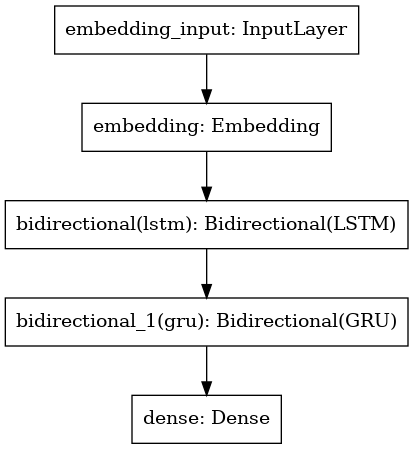

In [68]:
plot_model(model_w2v_Headlines, to_file='model_plot.png', show_shapes=False, show_layer_names=True)

**Train the model**

In [69]:
x_train, x_test, y_train, y_test = train_test_split(x, df2.is_sarcastic , test_size = 0.3 , random_state = 0) 


In [70]:
history_w2v_Headlines = model_w2v_Headlines.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)


2022-09-17 08:08:28.213649: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
157/157 [==============================] - 272s 2s/step - loss: 0.4965 - acc: 0.7488 - val_loss: 0.4131 - val_acc: 0.8072
Epoch 2/3
157/157 [==============================] - 259s 2s/step - loss: 0.1778 - acc: 0.9325 - val_loss: 0.4676 - val_acc: 0.8015
Epoch 3/3
157/157 [==============================] - 262s 2s/step - loss: 0.0631 - acc: 0.9790 - val_loss: 0.7601 - val_acc: 0.7855


In [71]:
# model_w2v_Headlines.save('./model_w2v_Headlines')
# np.save('history_w2v_Headlines.npy',history_w2v_Headlines.history)

In [72]:
# shutil.rmtree('./keras_metadata.pb')
# os.remove("./saved_model.pb")

In [73]:
# history_w2v_Headlines=np.load('history_w2v_Headlines.npy',allow_pickle='TRUE').item()
# model_w2v_Headlines = keras.models.load_model('./model_w2v_Headlines')


In [74]:
print("Accuracy of the w2v_Headlines model on Training Data is - " , model_w2v_Headlines.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the w2v_Headlines model on Testing Data is - " , model_w2v_Headlines.evaluate(x_test,y_test)[1]*100)


627/627 [==============================] - 59s 94ms/step - loss: 0.0300 - acc: 0.9911
Accuracy of the w2v_Headlines model on Training Data is -  99.1064727306366
269/269 [==============================] - 26s 95ms/step - loss: 0.7601 - acc: 0.7855
Accuracy of the w2v_Headlines model on Testing Data is -  78.54647040367126


In [75]:
print("Classification report for w2v_Headlines:")
pred = np.round_(model_w2v_Headlines.predict(x_test))
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))
cm = confusion_matrix(y_test,pred)
print('confusion matrix:\n')
print(cm)


Classification report for w2v_Headlines:
               precision    recall  f1-score   support

Not Sarcastic       0.85      0.73      0.78      4560
    Sarcastic       0.73      0.85      0.79      4026

     accuracy                           0.79      8586
    macro avg       0.79      0.79      0.79      8586
 weighted avg       0.79      0.79      0.79      8586

confusion matrix:

[[3321 1239]
 [ 603 3423]]


<AxesSubplot:>

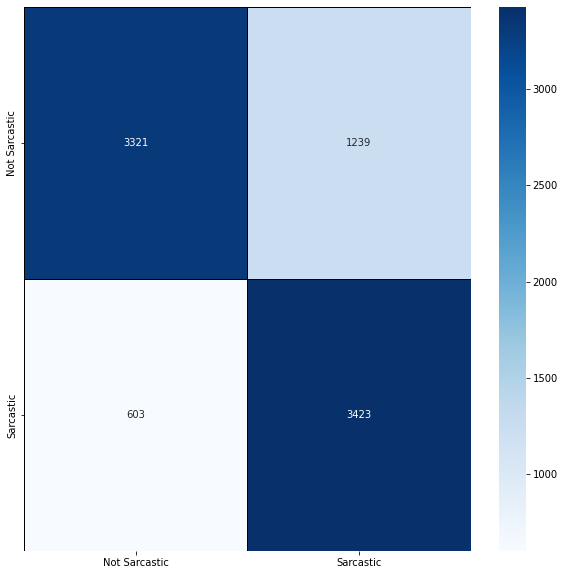

In [76]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic']) 
# plt.savefig("cm_w2v_Headlines.png")

****word2vec using googlenewsword2vec using googlenews****

**Extract the Word2Vec Embedding from the pre-trained googlenewsword2vec Embedding. We use the gensim library API for that purpose.**

**In the Embedding, each coefficients' vector has he size of 300, becasue Google-News Embedding has the same dimensions.**

**Extract the Word2Vec Embedding from googlenewsword2vec**

In [77]:
filename = '../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'
W2V_GoogleNews = KeyedVectors.load_word2vec_format(filename, binary=True)



**Create the weight matrix for words in training docs - embedding_matrix**

In [78]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 300))
for word, i in t.word_index.items():
    try:
        # update embedding matrix using Google's pretrained model
        embedding_vector = W2V_GoogleNews.get_vector(word, norm=True)
        embedding_matrix[i] = embedding_vector
    except:
        # when word isn't found in pretrained model, we keep the embedding matrix unchanged at that index (assigned to zero)
        pass


**Define the Neural Network**

same as that of headlines

In [79]:
#Defining Neural Network
model_W2V_GoogleNews = Sequential()
#Non-trainable embeddidng layer
model_W2V_GoogleNews.add(Embedding(vocab_size, output_dim=300, weights=[embedding_matrix], input_length=max_length, trainable=True))
#LSTM 
model_W2V_GoogleNews.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model_W2V_GoogleNews.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model_W2V_GoogleNews.add(Dense(1, activation='sigmoid'))
model_W2V_GoogleNews.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['acc'])


In [80]:
model_W2V_GoogleNews.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 106, 300)          8570400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 106, 256)          439296    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                55680     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 9,065,441
Trainable params: 9,065,441
Non-trainable params: 0
_________________________________________________________________


In [81]:
x_train, x_test, y_train, y_test = train_test_split(x, df2.is_sarcastic , test_size = 0.3 , random_state = 0) 


Pre-Trained Word2Vec of 'GoogleNews' Embedding

In [82]:
history_W2V_GoogleNews = model_W2V_GoogleNews.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)


Epoch 1/3
157/157 [==============================] - 272s 2s/step - loss: 0.4743 - acc: 0.7725 - val_loss: 0.3990 - val_acc: 0.8174
Epoch 2/3
157/157 [==============================] - 267s 2s/step - loss: 0.1609 - acc: 0.9409 - val_loss: 0.5295 - val_acc: 0.7982
Epoch 3/3
157/157 [==============================] - 267s 2s/step - loss: 0.0608 - acc: 0.9794 - val_loss: 0.6848 - val_acc: 0.8038


In [83]:
# model_W2V_GoogleNews.save('./model_W2V_GoogleNews')
# np.save('history_W2V_GoogleNews.npy',history_W2V_GoogleNews.history)

In [84]:
# history_W2V_GoogleNews=np.load('history_W2V_GoogleNews.npy',allow_pickle='TRUE').item()
# model_W2V_GoogleNews = keras.models.load_model('./model_W2V_GoogleNews')


In [85]:
print("Accuracy of the W2V_GoogleNews model on Training Data is - " , model_W2V_GoogleNews.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the W2V_GoogleNews model on Testing Data is - " , model_W2V_GoogleNews.evaluate(x_test,y_test)[1]*100)


627/627 [==============================] - 60s 96ms/step - loss: 0.0244 - acc: 0.9935
Accuracy of the W2V_GoogleNews model on Training Data is -  99.34607744216919
269/269 [==============================] - 26s 97ms/step - loss: 0.6848 - acc: 0.8038
Accuracy of the W2V_GoogleNews model on Testing Data is -  80.37502765655518


In [86]:
print("Classification report for W2V_GoogleNews:")
pred = np.round_(model_W2V_GoogleNews.predict(x_test))
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))
cm = confusion_matrix(y_test,pred)
print('confusion matrix:\n')
print(cm)


Classification report for W2V_GoogleNews:
               precision    recall  f1-score   support

Not Sarcastic       0.82      0.81      0.81      4560
    Sarcastic       0.79      0.80      0.79      4026

     accuracy                           0.80      8586
    macro avg       0.80      0.80      0.80      8586
 weighted avg       0.80      0.80      0.80      8586

confusion matrix:

[[3693  867]
 [ 818 3208]]


<AxesSubplot:>

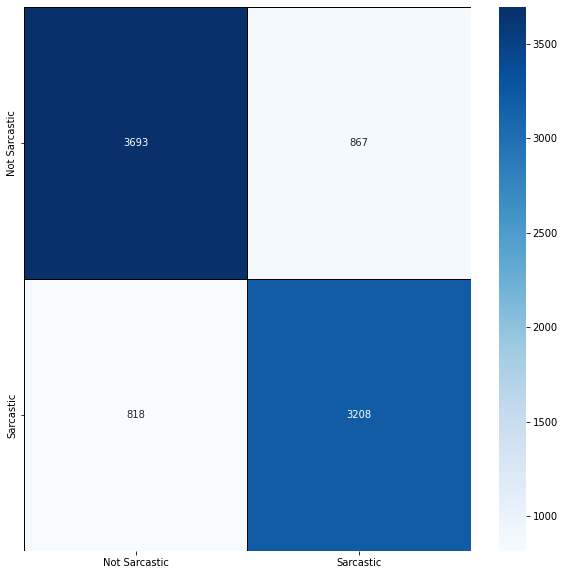

In [87]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic']) 
# plt.savefig("cm_W2V_GoogleNews.png")

**Glove using pre-trained tweeter**

**Load the whole embedding into memory - glove.twitter.27B.200d.txt**

In [88]:
file_path = '../input/glove-twitter/glove.twitter.27B.200d.txt'

In [89]:
# load the whole embedding into memory
embeddings_index = dict()
f = open(file_path, mode='rt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


**If you have already created and saved on this kaggle page the glove_twitter model and its history, you could upload them by executing the following commands:**

In [90]:
# history_glove_twitter=np.load('history_glove_twitter.npy',allow_pickle='TRUE').item()
# model_glove_twitter = keras.models.load_model('./model_glove_twitter')


In [91]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 200))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [92]:
#Defining Neural Network
model_glove_twitter = Sequential()
#Non-trainable embeddidng layer
model_glove_twitter.add(Embedding(vocab_size, output_dim=200, weights=[embedding_matrix], input_length=max_length, trainable=True))
#LSTM 
model_glove_twitter.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model_glove_twitter.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model_glove_twitter.add(Dense(1, activation='sigmoid'))
model_glove_twitter.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['acc'])


In [93]:
x_train, x_test, y_train, y_test = train_test_split(x, df2.is_sarcastic , test_size = 0.3 , random_state = 0) 


In [94]:
history_glove_twitter = model_glove_twitter.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)


Epoch 1/3
157/157 [==============================] - 272s 2s/step - loss: 0.4458 - acc: 0.7875 - val_loss: 0.3796 - val_acc: 0.8321
Epoch 2/3
157/157 [==============================] - 264s 2s/step - loss: 0.1610 - acc: 0.9373 - val_loss: 0.4835 - val_acc: 0.8298
Epoch 3/3
157/157 [==============================] - 267s 2s/step - loss: 0.0597 - acc: 0.9787 - val_loss: 0.6639 - val_acc: 0.8203


**If you would like to save on this kaggle page the glove_twitter model and its history, then operate the following commands:**

In [95]:
# model_glove_twitter.save('./model_glove_twitter')
# np.save('history_glove_twitter.npy',history_glove_twitter.history)

In [96]:
print("Accuracy of the glove_twitter model on Training Data is - " , model_glove_twitter.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the glove_twitter model on Testing Data is - " , model_glove_twitter.evaluate(x_test,y_test)[1]*100)


627/627 [==============================] - 65s 103ms/step - loss: 0.0180 - acc: 0.9954
Accuracy of the glove_twitter model on Training Data is -  99.53576326370239
269/269 [==============================] - 28s 104ms/step - loss: 0.6639 - acc: 0.8203
Accuracy of the glove_twitter model on Testing Data is -  82.02888369560242


In [97]:
print("Classification report for glove_twitter:")
pred = np.round_(model_glove_twitter.predict(x_test))
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))
cm = confusion_matrix(y_test,pred)
print('confusion matrix:\n')
print(cm)


Classification report for glove_twitter:
               precision    recall  f1-score   support

Not Sarcastic       0.85      0.81      0.83      4560
    Sarcastic       0.79      0.84      0.81      4026

     accuracy                           0.82      8586
    macro avg       0.82      0.82      0.82      8586
 weighted avg       0.82      0.82      0.82      8586

confusion matrix:

[[3674  886]
 [ 657 3369]]


<AxesSubplot:>

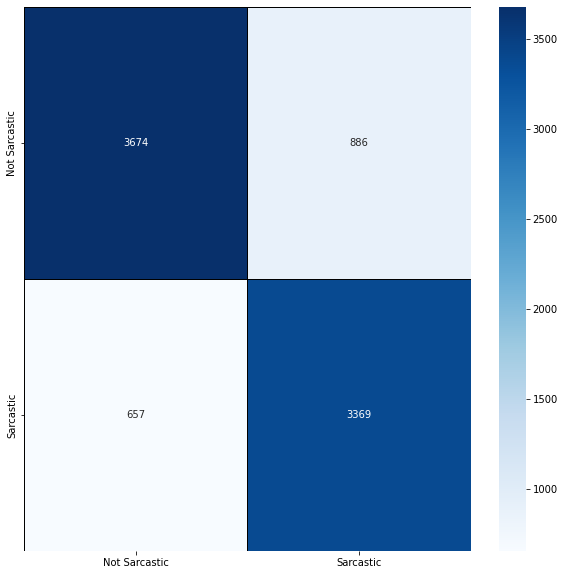

In [98]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic']) 
# plt.savefig("cm_glove_twitter.png")

**fasttext using pre-trained crawl**

**Load the whole embedding into memory - crawl-300d-2M.vec**

In [99]:
file_path = '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'

In [100]:
# load the whole embedding into memory
embeddings_index = dict()
f = open(file_path, mode='r')
for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 2000000 word vectors.


**If you have already created and saved on this kaggle page the fasttext model and its history, you could upload them by executing the following commands:**

In [101]:
# history_fasttext=np.load('history_fasttext.npy',allow_pickle='TRUE').item()
# model_fasttext = keras.models.load_model('./model_fasttext')


In [102]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [103]:
#Defining Neural Network
model_fasttext = Sequential()
#Non-trainable embeddidng layer
model_fasttext.add(Embedding(vocab_size, output_dim=300, weights=[embedding_matrix], input_length=max_length, trainable=True))
#LSTM 
model_fasttext.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model_fasttext.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model_fasttext.add(Dense(1, activation='sigmoid'))
model_fasttext.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['acc'])


In [104]:
model_fasttext.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 106, 300)          8570400   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 106, 256)          439296    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                55680     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 9,065,441
Trainable params: 9,065,441
Non-trainable params: 0
_________________________________________________________________


In [105]:
x_train, x_test, y_train, y_test = train_test_split(x, df2.is_sarcastic , test_size = 0.3 , random_state = 0) 


In [106]:
history_fasttext = model_fasttext.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)


Epoch 1/3
157/157 [==============================] - 284s 2s/step - loss: 0.4374 - acc: 0.7924 - val_loss: 0.3666 - val_acc: 0.8403
Epoch 2/3
157/157 [==============================] - 272s 2s/step - loss: 0.1475 - acc: 0.9445 - val_loss: 0.4568 - val_acc: 0.8317
Epoch 3/3
157/157 [==============================] - 269s 2s/step - loss: 0.0548 - acc: 0.9809 - val_loss: 0.6555 - val_acc: 0.8215


In [107]:
print("Accuracy of the fasttext model on Training Data is - " , model_fasttext.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the fasttext model on Testing Data is - " , model_fasttext.evaluate(x_test,y_test)[1]*100)


627/627 [==============================] - 61s 97ms/step - loss: 0.0161 - acc: 0.9967
Accuracy of the fasttext model on Training Data is -  99.6705412864685
269/269 [==============================] - 26s 96ms/step - loss: 0.6555 - acc: 0.8215
Accuracy of the fasttext model on Testing Data is -  82.14535117149353


**If you would like to save on this kaggle page the fasttext model and its history, then operate the following commands:**

In [108]:
# model_fasttext.save('./model_fasttext')
# np.save('history_fasttext.npy',history_fasttext.history)

In [109]:
print("Classification report for fasttext:")
pred = np.round_(model_fasttext.predict(x_test))
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))
cm = confusion_matrix(y_test,pred)
print('confusion matrix:\n')
print(cm)


Classification report for fasttext:
               precision    recall  f1-score   support

Not Sarcastic       0.85      0.81      0.83      4560
    Sarcastic       0.79      0.84      0.81      4026

     accuracy                           0.82      8586
    macro avg       0.82      0.82      0.82      8586
 weighted avg       0.82      0.82      0.82      8586

confusion matrix:

[[3691  869]
 [ 664 3362]]


<AxesSubplot:>

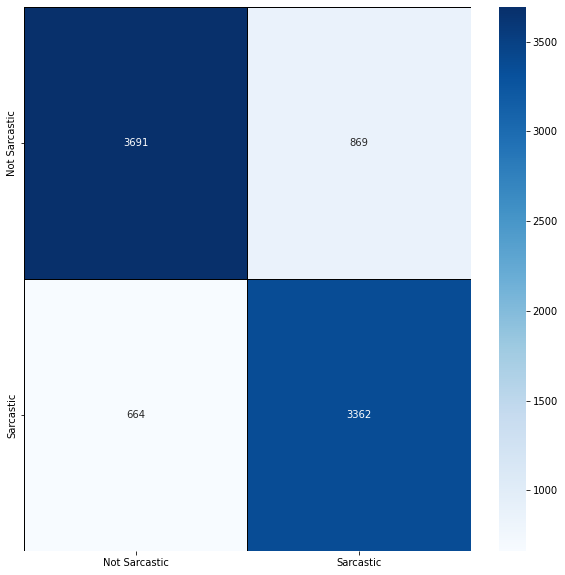

In [110]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic']) 
# plt.savefig("cm_fasttext.png")

In [122]:
train_acc_w2v_Headlines	  = history_w2v_Headlines.history['acc']
train_loss_w2v_Headlines  = history_w2v_Headlines.history['loss']
val_acc_w2v_Headlines     = history_w2v_Headlines.history['val_acc']
val_loss_w2v_Headlines    = history_w2v_Headlines.history['val_loss']

train_acc_W2V_GoogleNews	  = history_W2V_GoogleNews.history['acc']
train_loss_W2V_GoogleNews  = history_W2V_GoogleNews.history['loss']
val_acc_W2V_GoogleNews     = history_W2V_GoogleNews.history['val_acc']
val_loss_W2V_GoogleNews    = history_W2V_GoogleNews.history['val_loss']

train_acc_glove_twitter	  = history_glove_twitter.history['acc']
train_loss_glove_twitter  = history_glove_twitter.history['loss']
val_acc_glove_twitter     = history_glove_twitter.history['val_acc']
val_loss_glove_twitter    = history_glove_twitter.history['val_loss']

train_acc_fasttext	  = history_fasttext.history['acc']
train_loss_fasttext  = history_fasttext.history['loss']
val_acc_fasttext     = history_fasttext.history['val_acc']
val_loss_fasttext    = history_fasttext.history['val_loss']


data_preproc_val_acc = pd.DataFrame({
    'w2v_Headlines': val_acc_w2v_Headlines,
    'W2V_GoogleNews': val_acc_W2V_GoogleNews,
    'glove_twitter': val_acc_glove_twitter,
    'fasttext': val_acc_fasttext})
data_preproc_val_acc.index = np.arange(1, len(data_preproc_val_acc) + 1)

data_preproc_val_loss = pd.DataFrame({
    'w2v_Headlines': val_loss_w2v_Headlines,
    'W2V_GoogleNews': val_loss_W2V_GoogleNews,
    'glove_twitter': val_loss_glove_twitter,
    'fasttext': val_loss_fasttext})
data_preproc_val_loss.index = np.arange(1, len(data_preproc_val_loss) + 1)

data_preproc_train_acc = pd.DataFrame({
    'w2v_Headlines': train_acc_w2v_Headlines,
    'W2V_GoogleNews': train_acc_W2V_GoogleNews,
    'glove_twitter': train_acc_glove_twitter,
    'fasttext': train_acc_fasttext})
data_preproc_train_acc.index = np.arange(1, len(data_preproc_train_acc) + 1)

data_preproc_train_loss = pd.DataFrame({
    'w2v_Headlines': train_loss_w2v_Headlines,
    'W2V_GoogleNews': train_loss_W2V_GoogleNews,
    'glove_twitter': train_loss_glove_twitter,
    'fasttext': train_loss_fasttext})
data_preproc_train_loss.index = np.arange(1, len(data_preproc_train_loss) + 1)

[Text(0.5, 1.0, 'Training Loss')]

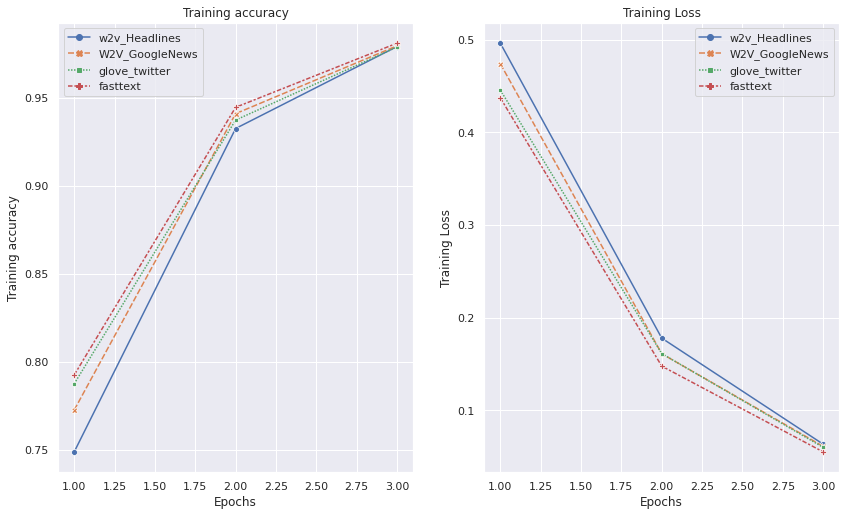

In [170]:
sns.set(rc={'figure.figsize':(14,8.27)})
fig, axes = plt.subplots(1, 2)

train_acc_plot = sns.lineplot(data=data_preproc_train_acc, markers=True, ax=axes[0])
train_acc_plot.set_xlabel("Epochs")
train_acc_plot.set_ylabel("Training accuracy")
train_acc_plot.set(title='Training accuracy')
# sns.move_legend(val_acc_plot, "upper left", bbox_to_anchor=(1, 1))

train_loss_plot = sns.lineplot(data=data_preproc_train_loss, markers=True, ax=axes[1])
train_loss_plot.set_xlabel("Epochs")
train_loss_plot.set_ylabel("Training Loss")
train_loss_plot.set(title='Training Loss')
# sns.move_legend(val_loss_plot, "upper left", bbox_to_anchor=(1, 1))

# fig.savefig('Training_res.png')


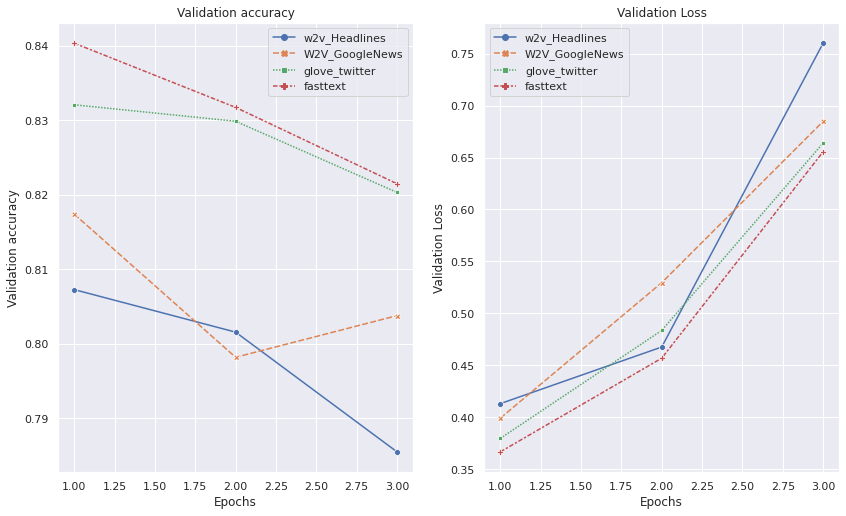

In [168]:
sns.set(rc={'figure.figsize':(14,8.27)})
fig, axes = plt.subplots(1, 2)

val_acc_plot = sns.lineplot(data=data_preproc_val_acc, markers=True, ax=axes[0])
val_acc_plot.set_xlabel("Epochs")
val_acc_plot.set_ylabel("Validation accuracy")
val_acc_plot.set(title='Validation accuracy')
# sns.move_legend(val_acc_plot, "upper left", bbox_to_anchor=(1, 1))

val_loss_plot = sns.lineplot(data=data_preproc_val_loss, markers=True, ax=axes[1])
val_loss_plot.set_xlabel("Epochs")
val_loss_plot.set_ylabel("Validation Loss")
val_loss_plot.set(title='Validation Loss')
# sns.move_legend(val_loss_plot, "upper left", bbox_to_anchor=(1, 1))

# fig.savefig('Validation_res.png')
